In [1]:
import numpy as np
np.random.seed(1234)

In [2]:
x

NameError: name 'x' is not defined

In [3]:
w

NameError: name 'w' is not defined

In [4]:
def logistic_model(inputs, weights, bias):
    z = np.dot(inputs, weights) + bias
    z = z - np.max(z, axis=1, keepdims=True) ## Safe softmax!
    _e = np.exp(z)
    logits = np.divide(_e, np.sum(_e, axis=1, keepdims=True))
    return logits

In [5]:
def ce_loss(output, target):
    return -1.0 * np.mean( np.sum(np.multiply(target, np.log(output)), axis=1) )

In [6]:
x = np.random.rand(5, 4)
w = np.random.randn(4, 3)
b = np.ones((1, 3))

t = np.zeros((5, 3))
t[0, 0] = 1
t[1, 0] = 1
t[2, 1] = 1
t[3, 1] = 1
t[4, 2] = 1

In [7]:
output = logistic_model(x+1, w, b)

In [8]:
ce_loss(output, t)

4.173286345846108

---

In [9]:
def gradients(logits, target, inputs):
    assert logits.shape == target.shape
    assert inputs.shape[0] == logits.shape[0]
    
    grad_z =  (logits - target) / (1.0 * target.shape[0])
    grad_w = np.dot(inputs.T, grad_z)
    grad_b = np.sum(grad_z, axis=0, keepdims=True)
    
    return grad_w, grad_b

In [52]:
eg_w, eg_b = gradients(logistic_model(x, w, b), t, x)
assert eg_w.shape == w.shape
assert eg_b.shape == b.shape

In [53]:
def update_params((w, b), (eg_w, eg_b), alpha = 0.5):
    assert w.shape == eg_w.shape
    assert b.shape == eg_b.shape
    
    return (w - alpha*eg_w, b - alpha*eg_b)

## Data

In [12]:
## Data loader.
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
print "train examples", mnist.train.num_examples
print "test examples", mnist.test.num_examples

/Users/tejaswin.p/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
train examples 55000
test examples 10000


In [103]:
## Hyper-parameters.
batch_size = 128
nfeats = 784
nclasses = 10
alpha = 0.5

w = np.random.rand(nfeats, nclasses)
b = np.ones((1, nclasses))

In [104]:
mnist.train.images.shape

(55000, 784)

In [105]:
print "Index, TestLoss, TestAcc\n"
for ix in range(500):
    x, t = mnist.train.next_batch(batch_size=batch_size)
    logits = logistic_model(x, w, b)
    loss = ce_loss(logits, t)
    
    grads = gradients(logits, t, x)
    w, b = update_params((w, b), grads, alpha)
    
    if (ix+1)%20 == 0:
        test_logits = logistic_model(mnist.test.images, w, b)
        test_acc = np.mean(np.argmax(test_logits, axis=1) == np.argmax(mnist.test.labels, axis=1))
        
        print ix+1, ce_loss(test_logits, mnist.test.labels), test_acc
        alpha = alpha * 0.8 ## Decay.

Index, TestLoss, TestAcc

20 0.7919588990334226 0.7462
40 0.617569627062128 0.8063
60 0.548573689794617 0.83
80 0.5069316827205343 0.8462
100 0.4947587983270563 0.8513
120 0.47277633598164603 0.8588
140 0.4641461323184614 0.8584
160 0.4557073985634448 0.8642
180 0.45120246591631874 0.8648
200 0.4446908654330392 0.8681
220 0.4427689447836362 0.8675
240 0.44020569683230903 0.8686
260 0.438150061061487 0.8696
280 0.4367076832809638 0.8696
300 0.4349167647799678 0.8712
320 0.43415625804959357 0.8712
340 0.43335523437222134 0.8708
360 0.4326888499910525 0.8705
380 0.4321614229902073 0.8712
400 0.43201964494921524 0.8713
420 0.43170946680786065 0.8715
440 0.43154365995911775 0.8717
460 0.43123304095906406 0.8712
480 0.4310337420647495 0.8715
500 0.43092341892063785 0.8716


In [16]:

test_logits.shape

(10000, 10)

In [106]:
np.mean(np.argmax(test_logits, axis=1) == np.argmax(mnist.test.labels, axis=1))

0.8716

In [107]:
np.mean(np.argmax(logistic_model(mnist.test.images, binarize(w), b), axis=1) == np.argmax(mnist.test.labels, axis=1))

0.5918

In [22]:
np.argmax(mnist.test.labels, axis=1).shape

(10000,)

## Binarization

In [61]:
def binarize(m):
    bm = np.ones_like(m)
    bm[m<0] = -1
    return bm

In [67]:
a1 = np.random.randn(2, 4)
print a1
print binarize(a1)

[[ 1.02541265  0.14457986 -0.16644927  0.27761987]
 [ 0.42070886 -0.14406326 -0.12995927 -1.18648191]]
[[ 1.  1. -1.  1.]
 [ 1. -1. -1. -1.]]


In [62]:
def clip(m):
    return np.clip(m, -1, 1)

In [80]:
clip(a1)

array([[ 1.        ,  0.14457986, -0.16644927,  0.27761987],
       [ 0.42070886, -0.14406326, -0.12995927, -1.        ]])

In [132]:
init_w = np.random.rand(nfeats, nclasses)
init_b = np.ones((1, nclasses))

In [163]:
init_w

array([[0.1671869 , 0.94312201, 0.96548493, ..., 0.1226064 , 0.8500636 ,
        0.28271384],
       [0.55284532, 0.03277215, 0.01243287, ..., 0.97765844, 0.66534894,
        0.32336725],
       [0.19336067, 0.92465858, 0.25953113, ..., 0.72830791, 0.81333838,
        0.60819221],
       ...,
       [0.33256   , 0.62599094, 0.12410161, ..., 0.31431781, 0.86553726,
        0.30433318],
       [0.06026287, 0.88145124, 0.14835653, ..., 0.57666451, 0.34344051,
        0.46983752],
       [0.64963246, 0.22747306, 0.4993977 , ..., 0.66657841, 0.53022261,
        0.15044505]])

In [165]:
## Binarization algorithm.
np.random.seed(1234)
w = init_w
b = init_b

alpha = 0.1
changes = 0

print "\n\tWITH BINARIZATION\n"
print "Index, TestLoss, TestAcc\n"
prev_loss = 0

weights_array = []
bias_array = []

for ix in range(100):
    x, t = mnist.train.next_batch(batch_size=batch_size)
    w_bin = binarize(w) ## Binarize before forward pass.
    
    logits = logistic_model(x, w_bin, b) ## Forward pass with binarized weights.
    loss = ce_loss(logits, t)
    
    grads = gradients(logits, t, x) ## Gradients agains the binarized weights.
    w, b = update_params((w, b), grads, alpha)
    weights_array.append(w)
    if ix==0:
        print "First step:\n", w
        
    w = clip(w) ## Clip.
    
    bias_array.append(b)
    
    if (ix+1)%200:
        test_logits = logistic_model(mnist.test.images, w_bin, b) ## Use binarized weights.
        test_acc = np.mean(np.argmax(test_logits, axis=1) == np.argmax(mnist.test.labels, axis=1))
        test_loss = ce_loss(test_logits, mnist.test.labels)
        
        print ix+1, test_loss, test_acc
        
        if prev_loss<test_loss:
            alpha = alpha * 1 ## Decay.
            changes += 1
            print "Updating alpha. Changes at", changes
        
        prev_loss = test_loss
            
#     if changes>4:
#         print "Exiting."
#         print "Last test loss:", test_loss
#         print "Last test accuracy:", test_acc
#         break


	WITH BINARIZATION

Index, TestLoss, TestAcc

First step:
[[0.1671869  0.94312201 0.96548493 ... 0.1226064  0.8500636  0.28271384]
 [0.55284532 0.03277215 0.01243287 ... 0.97765844 0.66534894 0.32336725]
 [0.19336067 0.92465858 0.25953113 ... 0.72830791 0.81333838 0.60819221]
 ...
 [0.33256    0.62599094 0.12410161 ... 0.31431781 0.86553726 0.30433318]
 [0.06026287 0.88145124 0.14835653 ... 0.57666451 0.34344051 0.46983752]
 [0.64963246 0.22747306 0.4993977  ... 0.66657841 0.53022261 0.15044505]]
1 2.302524758931709 0.1028
Updating alpha. Changes at 1
2 2.2447239541908743 0.1533
3 2.2544707514909463 0.1462
Updating alpha. Changes at 2
4 2.2206701585802384 0.1685
5 2.1857172552084925 0.1633
6 2.1816435334033417 0.1854
7 2.1210426394377735 0.1659
8 2.1623698864775296 0.1811
Updating alpha. Changes at 3
9 2.090605964969242 0.2328
10 1.9957822082416394 0.2383
11 1.9419251108595748 0.2455
12 1.8719697733672183 0.2968
13 1.8123306149497345 0.3388
14 1.753298101750083 0.4169
15 1.70787023578

In [173]:
weights_array[97-1]

array([[0.1671869 , 0.94312201, 0.96548493, ..., 0.1226064 , 0.8500636 ,
        0.28271384],
       [0.55284532, 0.03277215, 0.01243287, ..., 0.97765844, 0.66534894,
        0.32336725],
       [0.19336067, 0.92465858, 0.25953113, ..., 0.72830791, 0.81333838,
        0.60819221],
       ...,
       [0.33256   , 0.62599094, 0.12410161, ..., 0.31431781, 0.86553726,
        0.30433318],
       [0.06026287, 0.88145124, 0.14835653, ..., 0.57666451, 0.34344051,
        0.46983752],
       [0.64963246, 0.22747306, 0.4993977 , ..., 0.66657841, 0.53022261,
        0.15044505]])

In [185]:
w.shape

(784, 10)

In [175]:
diff = weights_array[98-1] - weights_array[97-1]

In [188]:
np.sum(binarize(weights_array[98-1]) != binarize(weights_array[97-1]))

31

7.6833673867100405


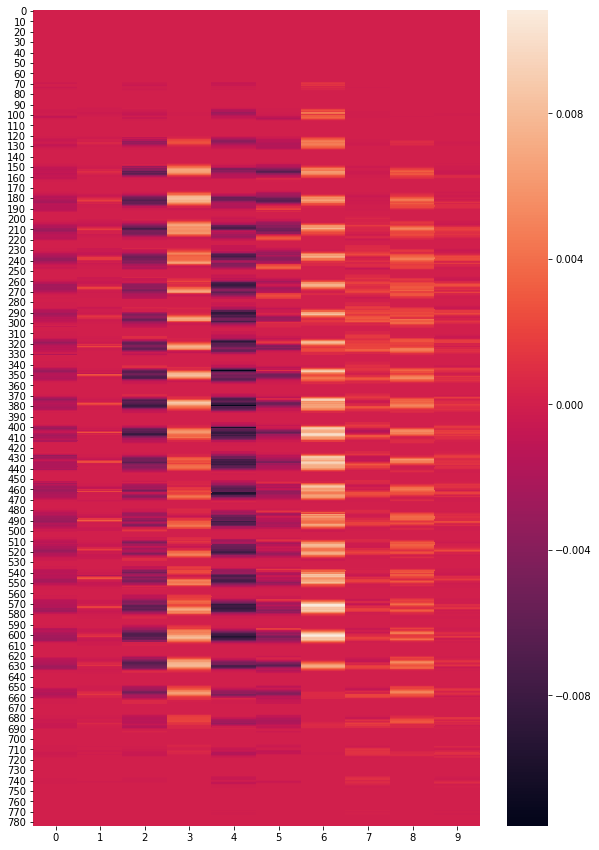

In [190]:
plt.figure(figsize=(10, 15))
sns.heatmap(diff)
plt.savefig("media/diff_heatmap")
print np.sum(np.abs(diff))

In [161]:
print weights_array[1]
print weights_array[-1]

[[0.1671869  0.94312201 0.96548493 ... 0.1226064  0.8500636  0.28271384]
 [0.55284532 0.03277215 0.01243287 ... 0.97765844 0.66534894 0.32336725]
 [0.19336067 0.92465858 0.25953113 ... 0.72830791 0.81333838 0.60819221]
 ...
 [0.33256    0.62599094 0.12410161 ... 0.31431781 0.86553726 0.30433318]
 [0.06026287 0.88145124 0.14835653 ... 0.57666451 0.34344051 0.46983752]
 [0.64963246 0.22747306 0.4993977  ... 0.66657841 0.53022261 0.15044505]]
[[0.1671869  0.94312201 0.96548493 ... 0.1226064  0.8500636  0.28271384]
 [0.55284532 0.03277215 0.01243287 ... 0.97765844 0.66534894 0.32336725]
 [0.19336067 0.92465858 0.25953113 ... 0.72830791 0.81333838 0.60819221]
 ...
 [0.33256    0.62599094 0.12410161 ... 0.31431781 0.86553726 0.30433318]
 [0.06026287 0.88145124 0.14835653 ... 0.57666451 0.34344051 0.46983752]
 [0.64963246 0.22747306 0.4993977  ... 0.66657841 0.53022261 0.15044505]]


In [191]:
!ls -lhtr media/

total 120
-rw-r--r--  1 tejaswin.p  1493847943    58K Jan 28 20:28 diff_heatmap.png


In [158]:
print bias_array[97-1]
print 
print bias_array[98-1]

[[0.94765708 1.25252627 0.93438733 0.98239388 1.04383126 0.98952777
  0.9326445  1.14521629 0.82472873 0.94708689]]

[[0.94975728 1.257233   0.93318784 0.9821512  1.04709511 0.99208559
  0.93614659 1.15148147 0.80639736 0.94446456]]


In [149]:
weights_array[-2] - weights_array[-1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [139]:
print b_bin

[[-1.  1.  1. -1.  1.  1.  1.  1. -1.  1.]]


In [130]:
np.mean(np.argmax(logistic_model(mnist.test.images, w_bin, b), axis=1) == np.argmax(mnist.test.labels, axis=1))

0.8159

In [131]:
np.mean(np.argmax(logistic_model(mnist.test.images, w, b), axis=1) == np.argmax(mnist.test.labels, axis=1))

0.8017

In [117]:
w_bin - w

array([[0.80848055, 0.37789123, 0.56227226, ..., 0.19812782, 0.04186065,
        0.12406737],
       [0.64218273, 0.49900487, 0.31653706, ..., 0.98623155, 0.22717338,
        0.11735881],
       [0.63511402, 0.38460382, 0.92461876, ..., 0.21126986, 0.68316388,
        0.43190135],
       ...,
       [0.9094552 , 0.53733388, 0.41349951, ..., 0.7094587 , 0.92372468,
        0.30947892],
       [0.1999725 , 0.58779077, 0.92819584, ..., 0.22138714, 0.42584852,
        0.1759952 ],
       [0.92068944, 0.02757976, 0.24600558, ..., 0.97323478, 0.49737843,
        0.05973111]])

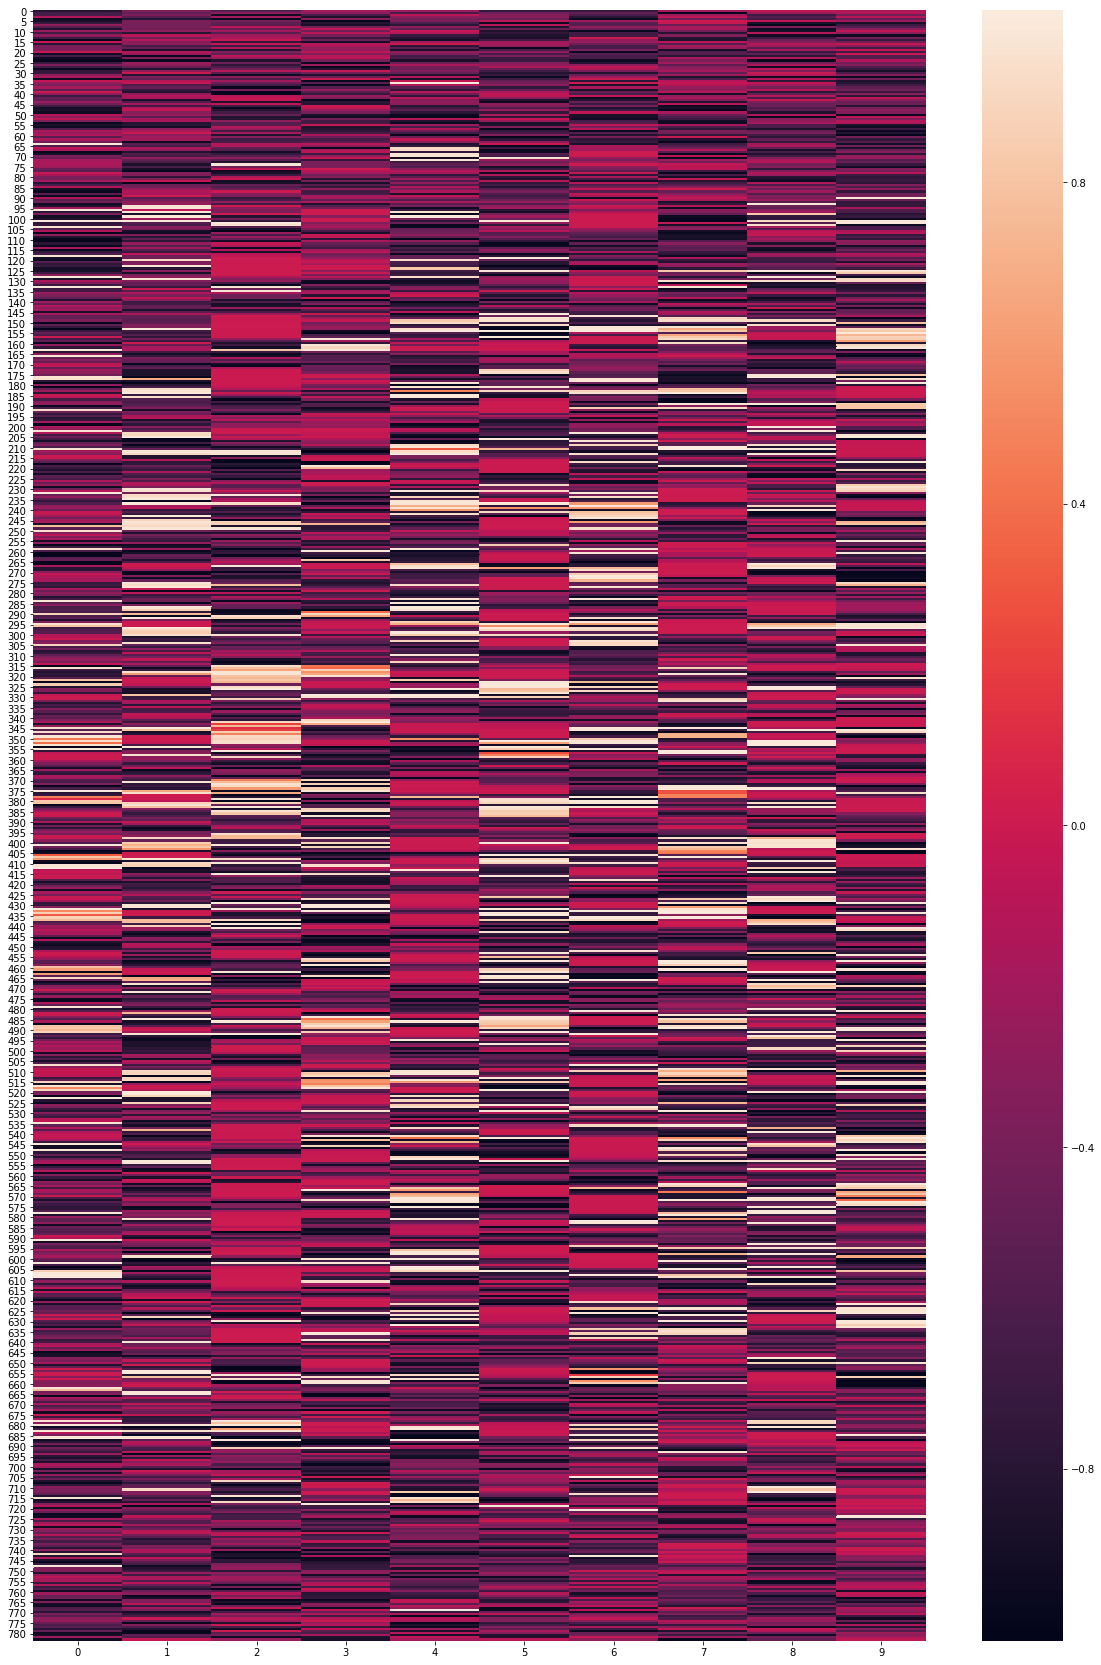

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,30))
sns.heatmap(w - w_bin)